In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=8ce6e9efe971be640730e093623161e74724ecdceb205cc66ff8c17baa5d8787
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
# Import necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import expr
from pyspark.sql.functions import col, sum, when, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql import Row
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import DataFrame

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spark = SparkSession.builder.master("local").appName("WeatherAnalysis").getOrCreate()

In [ ]:
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Datasets/Dataset.csv"

# Data Understanding:

In [ ]:
df =  spark.read.format("csv").option("header", "true").option("inferSchema","true").load(path)
df.show()

+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+--------+--------+----------+---------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Temp_min|Temp_max|Humidity|Wind Speed|Wind Gust|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+--------+--------+----------+---------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|     1.6|     3.9|    0.89|      null|     null|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|     2.7|     4.8|    0.87|      null|     null|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|     0.1|     4.8|    0.81|      null|     null|
|2000|    1|   4|Switzerland|Basel|          7|  1.0262|            0.

In [ ]:
df.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DATE: integer (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- Cloud_cover: integer (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- Global_radiation: double (nullable = true)
 |-- Precipitation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- Temp_mean: double (nullable = true)
 |-- Temp_min: double (nullable = true)
 |-- Temp_max: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Wind Gust: double (nullable = true)



In [ ]:
# Get the number of rows (equivalent to shape[0] in pandas)
num_rows = df.count()
print("Number of rows:", num_rows)

# Get the number of columns
num_columns = len(df.columns)
print("Number of columns:", num_columns)


Number of rows: 65754
Number of columns: 16


#Data Preprocessing

In [ ]:
# Count the number of null values in each column
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Show the null counts for each column
null_counts.show()

+----+-----+----+-------+----+-----------+--------+----------------+-------------+--------+---------+--------+--------+--------+----------+---------+
|YEAR|MONTH|DATE|COUNTRY|CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Temp_min|Temp_max|Humidity|Wind Speed|Wind Gust|
+----+-----+----+-------+----+-----------+--------+----------------+-------------+--------+---------+--------+--------+--------+----------+---------+
|   0|    0|   0|      0|   0|      18265|   10959|            7306|         3653|   14612|        0|    3653|       0|    7306|     21930|    40183|
+----+-----+----+-------+----+-----------+--------+----------------+-------------+--------+---------+--------+--------+--------+----------+---------+



In [ ]:
# droping columns "Wind Gust", "Wind Speed","Temp_min" and "Temp_max"
columns_to_drop = ['Wind Gust','Wind Speed', 'Temp_min', 'Temp_max']
df =df.drop(*columns_to_drop)

In [ ]:
df.show()

+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|    0.89|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|    0.87|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|    0.81|
|2000|    1|   4|Switzerland|Basel|          7|  1.0262|            0.63|         0.35|     6.9|      3.9|    0.79|
|2000|    1|   5|Switzerland|Basel|          5|  1.0246|            0.51|         0.07|     3.7|      6.0|     0.9|
|2000|    1|   6|Switzerland|Basel|          3|  1.0244|            0.56

In [ ]:
# dropping records of Malmo and Roma city
condition_column = "CITY"

condition_value_1 = "Malmo"
condition_value_2 = "Roma"

# Using filter() method with multiple conditions
df = df.filter((df[condition_column] != condition_value_1) & (df[condition_column] != condition_value_2))
df.show()


+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|    0.89|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|    0.87|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|    0.81|
|2000|    1|   4|Switzerland|Basel|          7|  1.0262|            0.63|         0.35|     6.9|      3.9|    0.79|
|2000|    1|   5|Switzerland|Basel|          5|  1.0246|            0.51|         0.07|     3.7|      6.0|     0.9|
|2000|    1|   6|Switzerland|Basel|          3|  1.0244|            0.56

In [ ]:
# Get the number of rows
num_rows = df.count()
print("Number of rows:", num_rows)

# Get the number of columns
num_columns = len(df.columns)
print("Number of columns:", num_columns)


Number of rows: 58448
Number of columns: 12


In [ ]:
# Fill NaN values with zeros
df = df.fillna(0)

In [ ]:
# Count the number of null values in each column
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

# Show the null counts for each column
null_counts.show()

+----+-----+----+-------+----+-----------+--------+----------------+-------------+--------+---------+--------+
|YEAR|MONTH|DATE|COUNTRY|CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|
+----+-----+----+-------+----+-----------+--------+----------------+-------------+--------+---------+--------+
|   0|    0|   0|      0|   0|          0|       0|               0|            0|       0|        0|       0|
+----+-----+----+-------+----+-----------+--------+----------------+-------------+--------+---------+--------+



In [ ]:
df.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DATE: integer (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- Cloud_cover: integer (nullable = true)
 |-- Pressure: double (nullable = false)
 |-- Global_radiation: double (nullable = false)
 |-- Precipitation: double (nullable = false)
 |-- Sunshine: double (nullable = false)
 |-- Temp_mean: double (nullable = false)
 |-- Humidity: double (nullable = false)



In [ ]:
df.describe().show()

+-------+------------------+------------------+------------------+-------+-----+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|summary|              YEAR|             MONTH|              DATE|COUNTRY| CITY|       Cloud_cover|          Pressure|  Global_radiation|      Precipitation|         Sunshine|         Temp_mean|          Humidity|
+-------+------------------+------------------+------------------+-------+-----+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+
|  count|             58448|             58448|             58448|  58448|58448|             58448|             58448|             58448|              58448|            58448|             58448|             58448|
|   mean|2004.4995893785929| 6.522310429783739|15.731453599781002|   null| null|3.9513926909389543|0.8888634786476757|1.2679107924993338|0.23455

In [ ]:
df.select("CITY").distinct().show()

+----------+
|      CITY|
+----------+
| Stockholm|
|   De-Blit|
|      Oslo|
|   Dresden|
|Montelimar|
|Dusseldorf|
| Ljubljana|
|    Kassel|
|   Munchen|
|Maastricht|
|     Tours|
| Perpignan|
|     Basel|
| Sonnblick|
|  Heathrow|
|  Budapest|
+----------+



#Weather Suitability Analysis

In [ ]:
# Define weights for tremperature and precipitation
weight_temperature = 0.3
weight_precipitation = 0.4    # prioritize precipitation

# Define suitability thresholds
suitable_threshold = 0.6
moderate_threshold = 0.4

In [ ]:

# function to calculate weather suitability score
def calculate_suitability_score(Temp_mean, Precipitation):
  suitability_score = []
  temperature_score = []
  precipitation_score = []
  weather_class = []

    # Normalize parameters to a scale between 0 and 1 (min-max normalization)
  for i in range(len(Temp_mean)):
    Temperature_score = (Temp_mean[i] - min(Temp_mean)) / (max(Temp_mean) - min(Temp_mean))
    Precipitation_score = 1.0 - (Precipitation[i] / max(Precipitation))

    # Calculate the suitability score for each day in the city
    Suitability_score = (weight_temperature * Temperature_score + weight_precipitation * Precipitation_score)

      # Classify the weather based on the suitability score
    if Suitability_score >= suitable_threshold:
      Weather_class = "Suitable"
    elif Suitability_score >= moderate_threshold:
      Weather_class = "Moderate"
    else:
      Weather_class = "Not Suitable"

    # adding the score to the list
    temperature_score.append(Temperature_score)
    precipitation_score.append(Precipitation_score)
    suitability_score.append(Suitability_score)
    weather_class.append(Weather_class)


  return suitability_score, temperature_score, precipitation_score, weather_class


In [ ]:
# Convert columns into an array
temp_array = df.select(collect_list("Temp_mean")).rdd.flatMap(lambda x: x[0]).collect()
precipitation_array = df.select(collect_list("Precipitation")).rdd.flatMap(lambda x: x[0]).collect()

# Apply UDFs to calculate scores and classify weather
suitability_score, temperature_score, precipitation_score, weather_class = calculate_suitability_score(temp_array,precipitation_array)


In [ ]:
len(weather_class)

58448

In [ ]:
# Define the schema for the empty DataFrame
schema = StructType([
    StructField("Temperature_Score", DoubleType(), True),
    StructField("Precipitation_Score", DoubleType(), True),
    StructField("Suitability_Score", DoubleType(), True),
    StructField("Weather_Class", StringType(), True)
])

In [ ]:
# Create a list of Row objects with the arrays
data = [Row(Temperature_Score = value1, Precipitation_Score = value2, Suitability_Score = value3, Weather_Class = value4) for value1, value2, value3, value4 in zip(temperature_score, precipitation_score, suitability_score, weather_class)]

# Create the DataFrame
result_df = spark.createDataFrame(data, schema)


In [ ]:
result_df.show()

+-------------------+-------------------+------------------+-------------+
|  Temperature_Score|Precipitation_Score| Suitability_Score|Weather_Class|
+-------------------+-------------------+------------------+-------------+
| 0.4941373534338358| 0.9981296758104738|0.5474930763543403|     Moderate|
| 0.5058626465661642|                1.0|0.5517587939698493|     Moderate|
| 0.4824120603015075|                1.0|0.5447236180904522|     Moderate|
| 0.5108877721943048| 0.9781795511221945|0.5445381521071693|     Moderate|
| 0.5460636515912898| 0.9956359102244389|0.5620734595671625|     Moderate|
| 0.5159128978224455|                1.0|0.5547738693467337|     Moderate|
|   0.52428810720268|                1.0| 0.557286432160804|     Moderate|
| 0.5393634840871022|                1.0|0.5618090452261306|     Moderate|
| 0.5226130653266332| 0.9594763092269327| 0.540574443288763|     Moderate|
| 0.4857621440536013| 0.9943890274314214| 0.543484254188649|     Moderate|
| 0.4991624790619765|    

In [ ]:

# Generate a unique identifier for each row in both DataFrames
df = df.withColumn("row_id", monotonically_increasing_id())
result_df = result_df.withColumn("row_id", monotonically_increasing_id())

# Perform an inner join based on the generated 'row_id' column
df = df.join(result_df.select('row_id', 'Weather_Class'), on='row_id', how='inner').drop('row_id')

df.show()

+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|Weather_Class|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|    0.89|     Moderate|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|    0.87|     Moderate|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|    0.81|     Moderate|
|2000|    1|   4|Switzerland|Basel|          7|  1.0262|            0.63|         0.35|     6.9|      3.9|    0.79|     Moderate|
|2000|    1|   5|Switzerland|Basel|          5|  1.0246|            0.51|         0.07|   

In [ ]:
result_df.show()

+-------------------+-------------------+------------------+-------------+------+
|  Temperature_Score|Precipitation_Score| Suitability_Score|Weather_Class|row_id|
+-------------------+-------------------+------------------+-------------+------+
| 0.4941373534338358| 0.9981296758104738|0.5474930763543403|     Moderate|     0|
| 0.5058626465661642|                1.0|0.5517587939698493|     Moderate|     1|
| 0.4824120603015075|                1.0|0.5447236180904522|     Moderate|     2|
| 0.5108877721943048| 0.9781795511221945|0.5445381521071693|     Moderate|     3|
| 0.5460636515912898| 0.9956359102244389|0.5620734595671625|     Moderate|     4|
| 0.5159128978224455|                1.0|0.5547738693467337|     Moderate|     5|
|   0.52428810720268|                1.0| 0.557286432160804|     Moderate|     6|
| 0.5393634840871022|                1.0|0.5618090452261306|     Moderate|     7|
| 0.5226130653266332| 0.9594763092269327| 0.540574443288763|     Moderate|     8|
| 0.485762144053

In [ ]:
# Use the `when` function to replace the "Weather_Class" column with numeric values
df = df.withColumn("Weather_Class", when(df["Weather_Class"] == "Moderate", 1)
                                    .when(df["Weather_Class"] == "Not Suitable", 0)
                                    .when(df["Weather_Class"] == "Suitable", 2)
                                    .otherwise(lit(None)))
df.show()

+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|Weather_Class|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|    0.89|            1|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|    0.87|            1|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|    0.81|            1|
|2000|    1|   4|Switzerland|Basel|          7|  1.0262|            0.63|         0.35|     6.9|      3.9|    0.79|            1|
|2000|    1|   5|Switzerland|Basel|          5|  1.0246|            0.51|         0.07|   

In [ ]:
# Get the number of rows
num_rows = df.count()
print("Number of rows:", num_rows)

# Get the number of columns
num_columns = len(df.columns)
print("Number of columns:", num_columns)


Number of rows: 58448
Number of columns: 13


#Data Visualiation:

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df.toPandas()
pandas_df

,YEAR,MONTH,DATE,COUNTRY,CITY,Cloud_cover,Pressure,Global_radiation,Precipitation,Sunshine,Temp_mean,Humidity,Weather_Class
0,2000,1,1,Switzerland,Basel,8,1.0286,0.20,0.03,0.0,2.9,0.89,1
1,2000,1,2,Switzerland,Basel,8,1.0318,0.25,0.00,0.0,3.6,0.87,1
2,2000,1,3,Switzerland,Basel,5,1.0314,0.50,0.00,3.7,2.2,0.81,1
3,2000,1,4,Switzerland,Basel,7,1.0262,0.63,0.35,6.9,3.9,0.79,1
4,2000,1,5,Switzerland,Basel,5,1.0246,0.51,0.07,3.7,6.0,0.90,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58443,2009,12,27,France,Tours,0,1.0091,0.58,0.08,0.0,4.6,0.84,1
58444,2009,12,28,France,Tours,0,1.0011,0.22,1.50,0.0,6.2,0.95,1
58445,2009,12,29,France,Tours,0,0.9966,0.24,0.40,0.0,10.4,0.89,1
58446,2009,12,30,France,Tours,0,0.9939,0.24,1.00,0.0,10.0,0.88,1


In [ ]:
pandas_results_df = (result_df.drop('row_id')).toPandas()
pandas_results_df

,Temperature_Score,Precipitation_Score,Suitability_Score,Weather_Class
0,0.494137,0.998130,0.547493,Moderate
1,0.505863,1.000000,0.551759,Moderate
2,0.482412,1.000000,0.544724,Moderate
3,0.510888,0.978180,0.544538,Moderate
4,0.546064,0.995636,0.562073,Moderate
...,...,...,...,...
58443,0.522613,0.995012,0.554789,Moderate
58444,0.549414,0.906484,0.527418,Moderate
58445,0.619765,0.975062,0.575955,Moderate
58446,0.613065,0.937656,0.558982,Moderate


<ipython-input-33-2dcba7060948>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = pandas_results_df.corr()


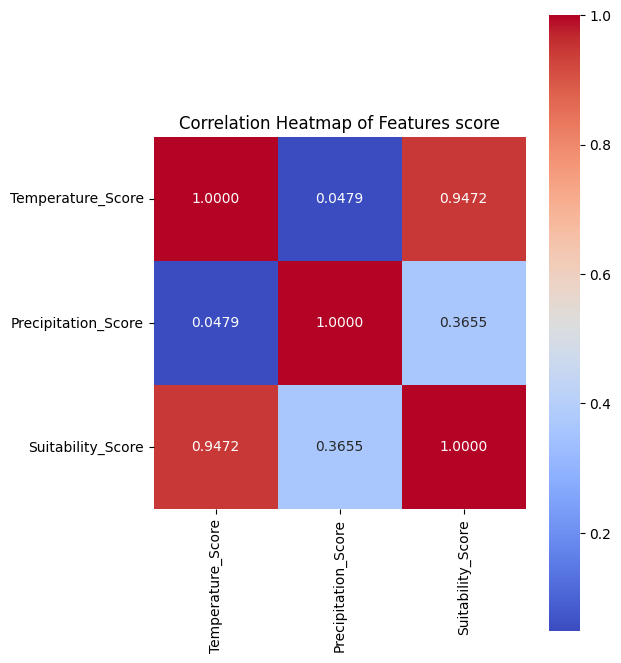

In [ ]:
# Calculate the correlation matrix
corr_matrix = pandas_results_df.corr()
# Create a heatmap
plt.figure(figsize=(6,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", square=True)
plt.title("Correlation Heatmap of Features score")
plt.show()

<ipython-input-34-f8ecc01e0e21>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = pandas_df.corr()


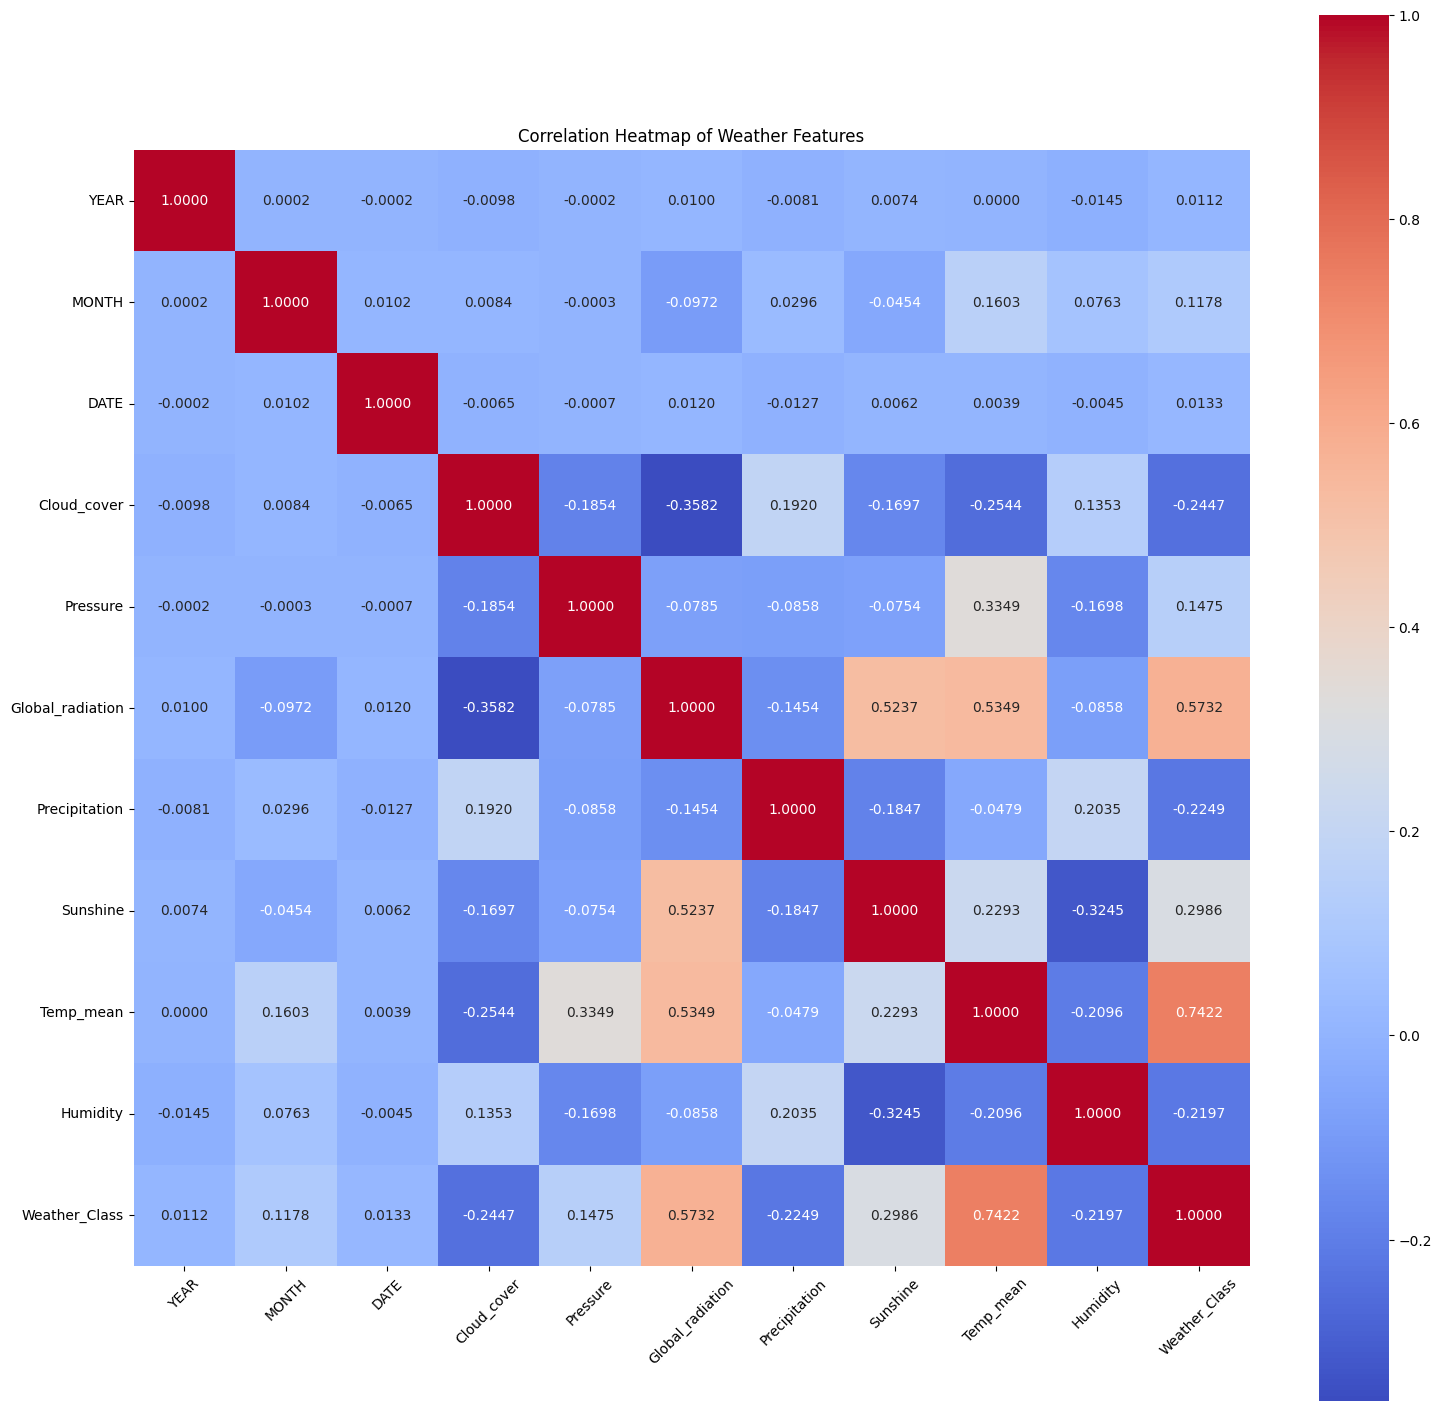

In [ ]:
# Calculate the correlation matrix
correlation_matrix = pandas_df.corr()

# Create a heatmap
plt.figure(figsize=(18,18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", square=True)

# Customize plot labels
plt.title("Correlation Heatmap of Weather Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

**Plot of weather suitability of each city**

<Figure size 1000x1000 with 0 Axes>

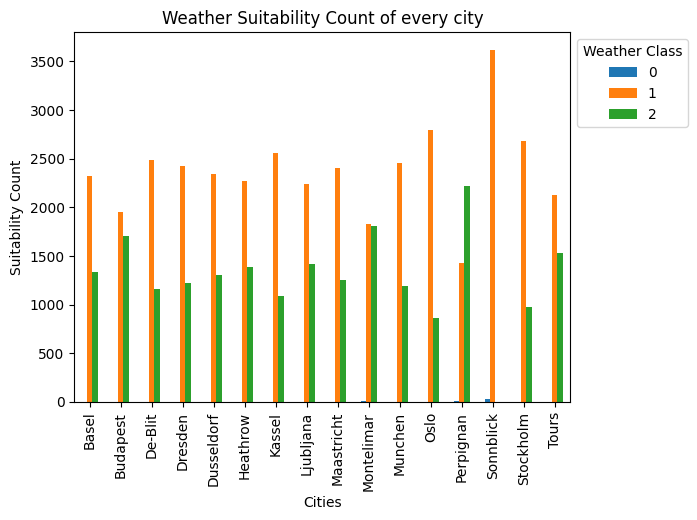

In [ ]:
# plotting a graph weather suitability for each city
crosstab_df = pd.crosstab(pandas_df['CITY'], pandas_df['Weather_Class'])

# Create a clustered bar plot
plt.figure(figsize=(10,10))  # Set the figure size
crosstab_df.plot(kind='bar', stacked=False)  # Create the clustered bar plot

plt.xlabel('Cities')  # Set the x-axis label
plt.ylabel('Suitability Count')  # Set the y-axis label
plt.title('Weather Suitability Count of every city')  # Set the plot title

plt.legend(title='Weather Class', bbox_to_anchor=(1, 1))  # Add a legend
plt.show()  # Show the plot


**Plot of weather suitability over a decade**

<Figure size 1000x1000 with 0 Axes>

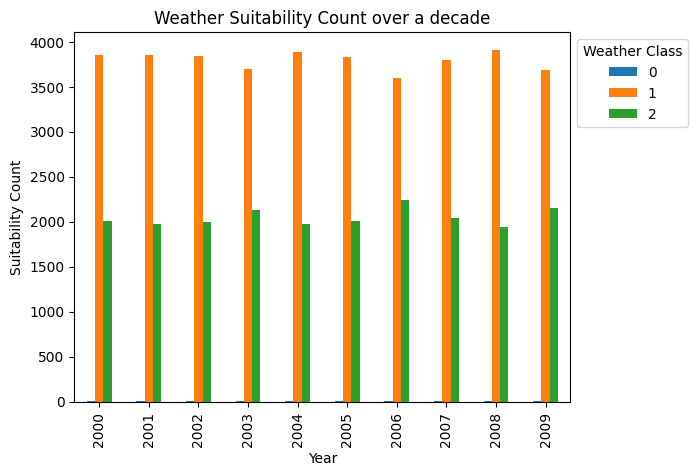

In [ ]:
# plotting a graph weather suitability through a decade
crosstab_df = pd.crosstab(pandas_df['YEAR'], pandas_df['Weather_Class'])
# Create a clustered bar plot
plt.figure(figsize=(10,10))  # Set the figure size
crosstab_df.plot(kind='bar', stacked=False)  # Create the clustered bar plot

plt.xlabel('Year')  # Set the x-axis label
plt.ylabel('Suitability Count')  # Set the y-axis label
plt.title('Weather Suitability Count over a decade')  # Set the plot title

plt.legend(title='Weather Class', bbox_to_anchor=(1, 1))  # Add a legend
plt.show()  # Show the plot

**Plot of weather suitability of each city over a decade**

<Figure size 1000x600 with 0 Axes>

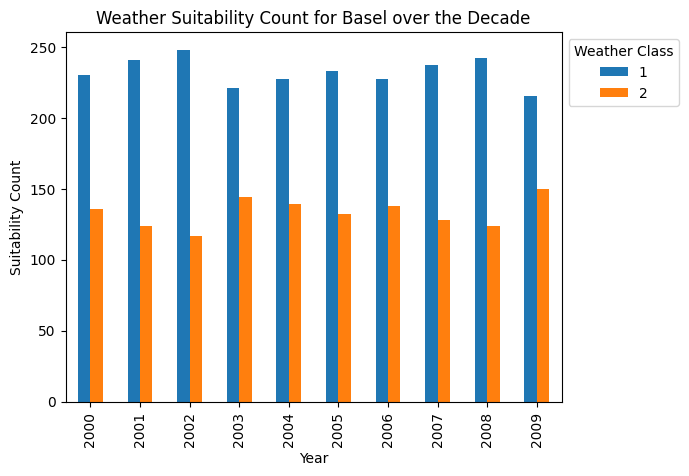

<Figure size 1000x600 with 0 Axes>

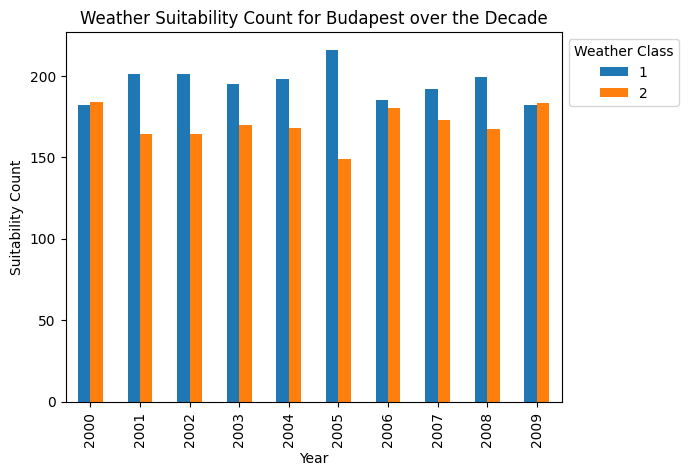

<Figure size 1000x600 with 0 Axes>

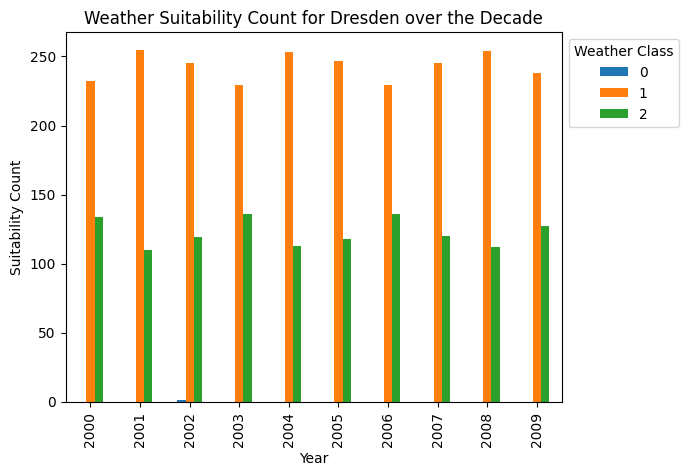

<Figure size 1000x600 with 0 Axes>

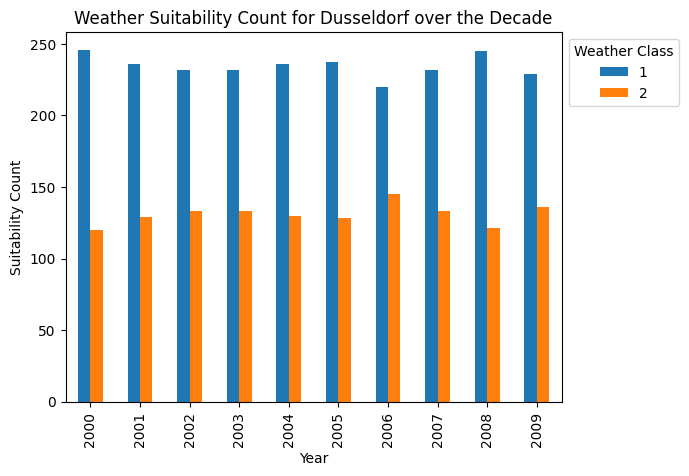

<Figure size 1000x600 with 0 Axes>

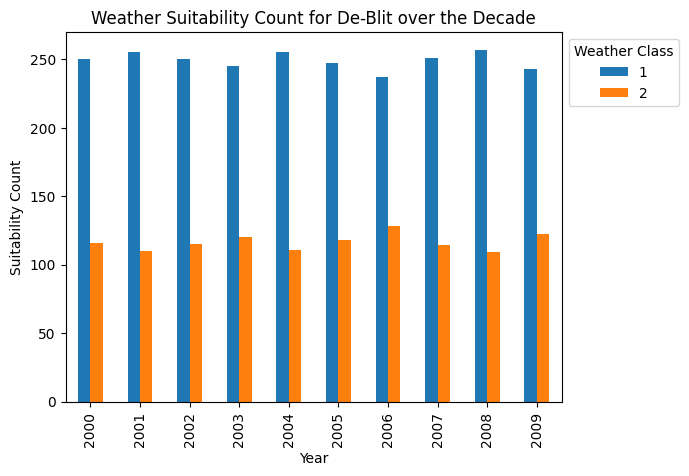

<Figure size 1000x600 with 0 Axes>

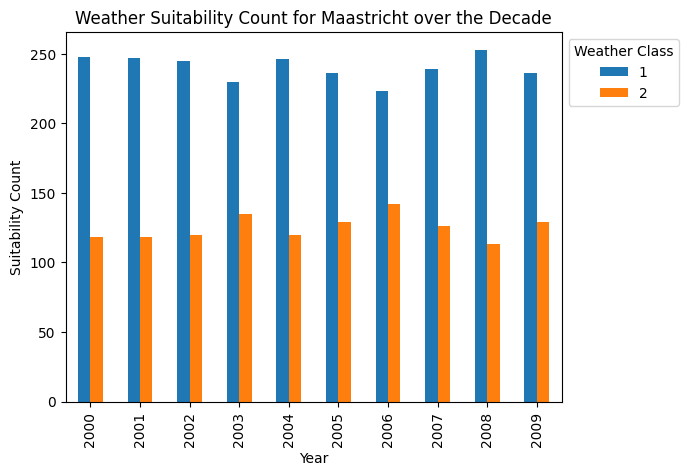

<Figure size 1000x600 with 0 Axes>

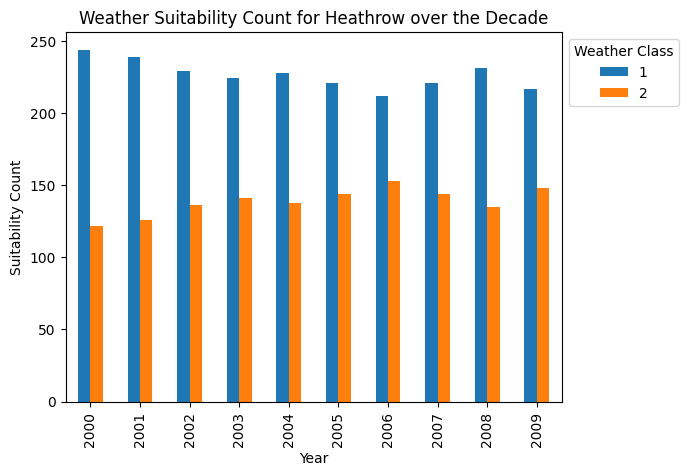

<Figure size 1000x600 with 0 Axes>

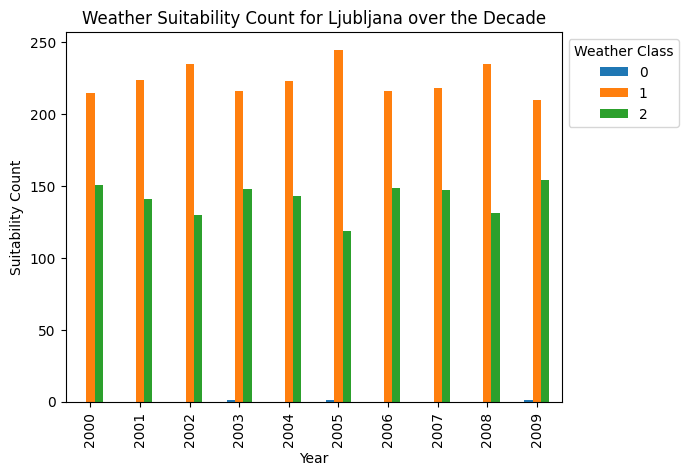

<Figure size 1000x600 with 0 Axes>

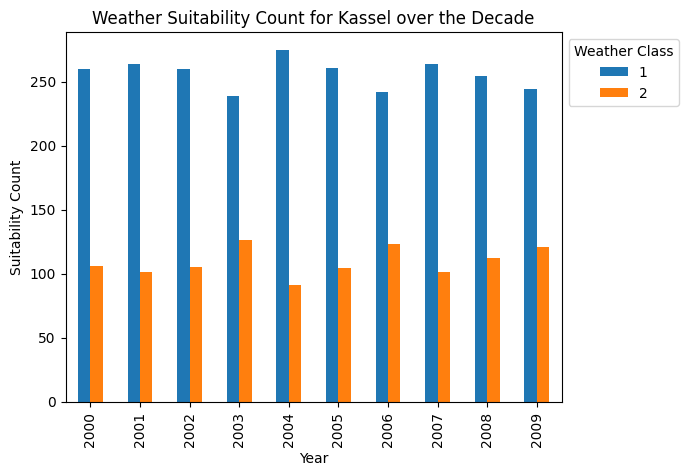

<Figure size 1000x600 with 0 Axes>

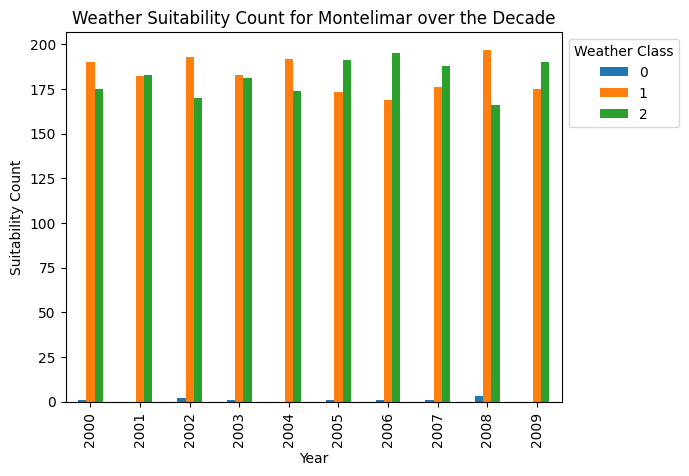

<Figure size 1000x600 with 0 Axes>

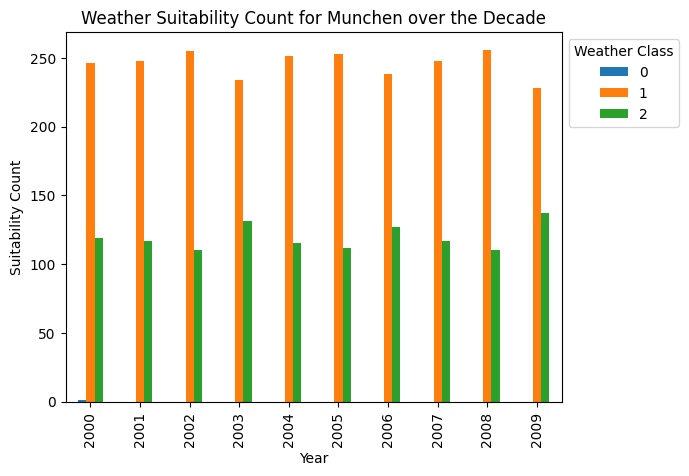

<Figure size 1000x600 with 0 Axes>

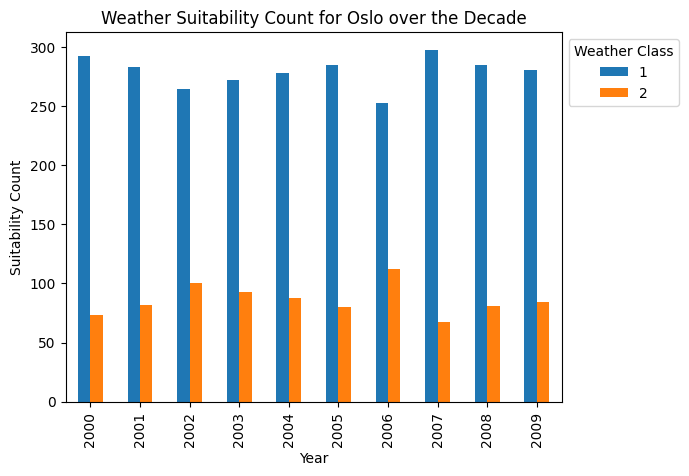

<Figure size 1000x600 with 0 Axes>

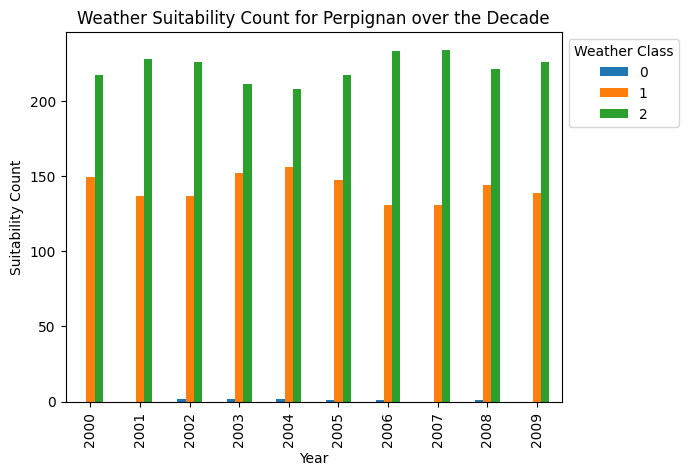

<Figure size 1000x600 with 0 Axes>

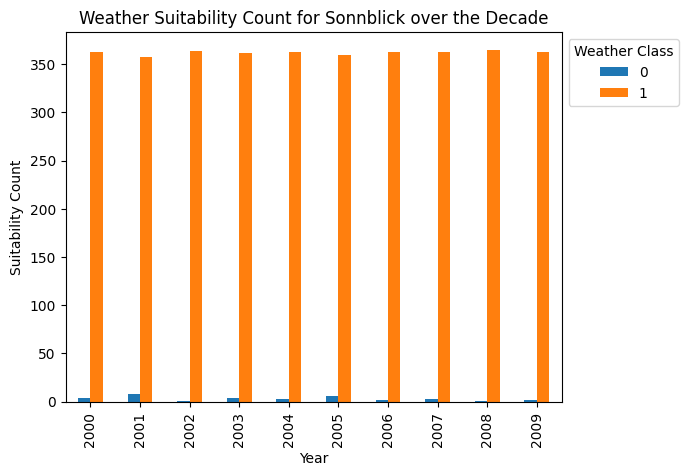

<Figure size 1000x600 with 0 Axes>

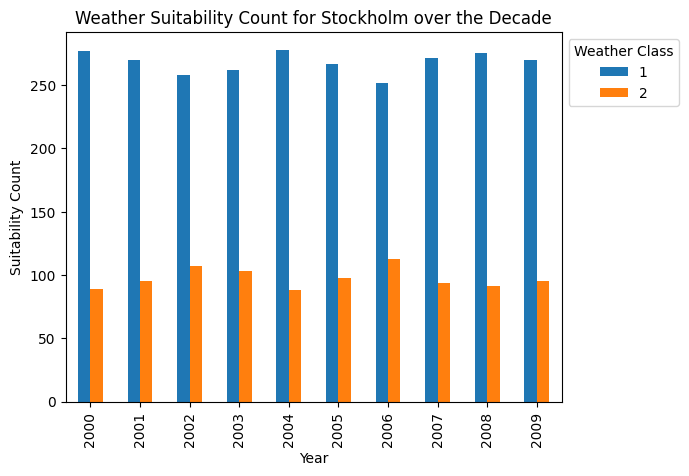

<Figure size 1000x600 with 0 Axes>

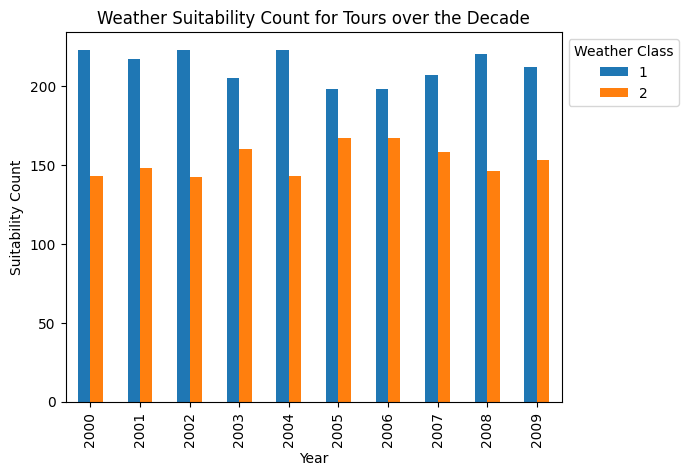

In [ ]:
# # plotting a graph weather suitability through a decade of an each city
unique_cities = pandas_df['CITY'].unique()

# Iterate through each city and create a separate plot
for city in unique_cities:
    # Filter the DataFrame for the current city
    city_df = pandas_df[pandas_df['CITY'] == city]

    # Create a crosstab for the current city
    crosstab_df = pd.crosstab(city_df['YEAR'], city_df['Weather_Class'])

    # Create a clustered bar plot for the current city
    plt.figure(figsize=(10, 6))  # Set the figure size
    crosstab_df.plot(kind='bar', stacked=False)  # Create the clustered bar plot

    plt.xlabel('Year')  # Set the x-axis label
    plt.ylabel('Suitability Count')  # Set the y-axis label
    plt.title(f'Weather Suitability Count for {city} over the Decade')  # Set the plot title

    plt.legend(title='Weather Class', bbox_to_anchor=(1, 1))  # Add a legend
    plt.show()  # Show the plot


**Plot of weather suitability of each city by month**

<Figure size 1000x600 with 0 Axes>

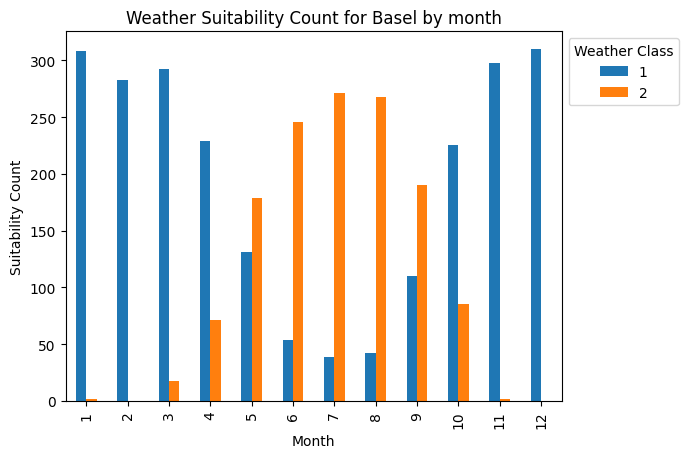

<Figure size 1000x600 with 0 Axes>

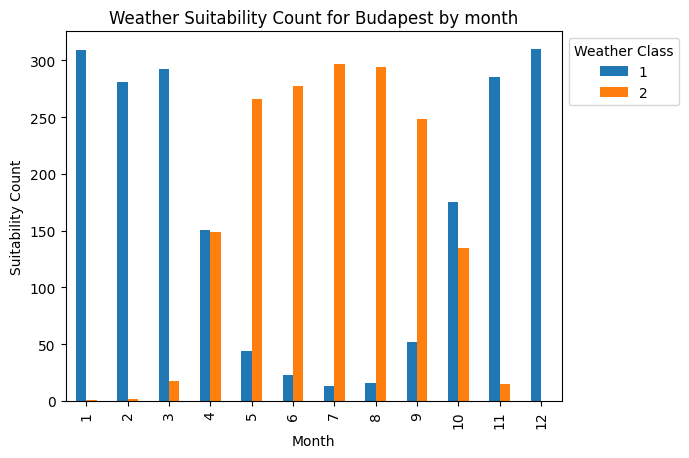

<Figure size 1000x600 with 0 Axes>

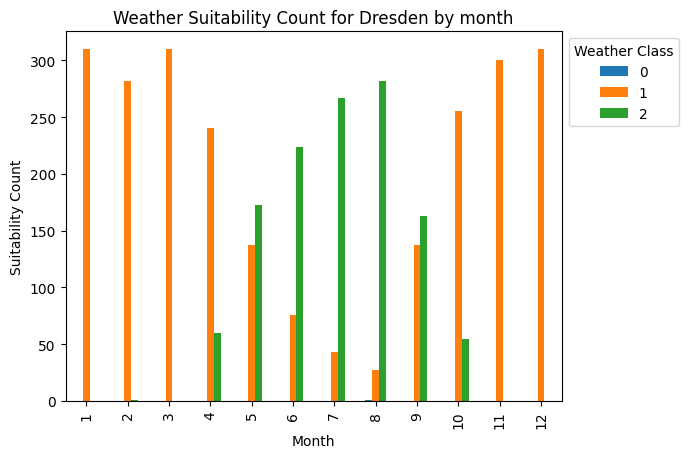

<Figure size 1000x600 with 0 Axes>

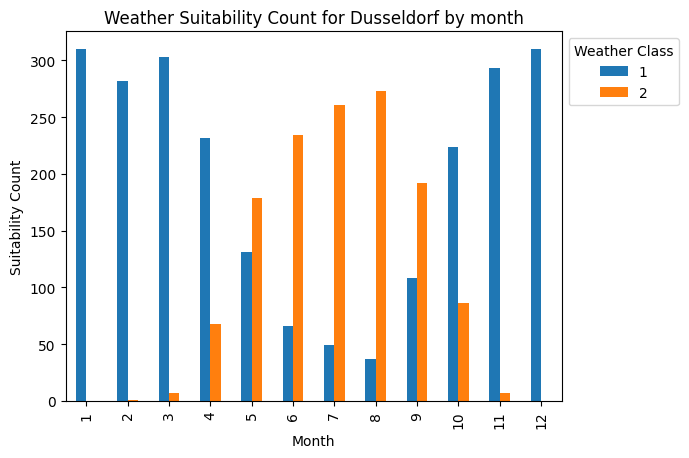

<Figure size 1000x600 with 0 Axes>

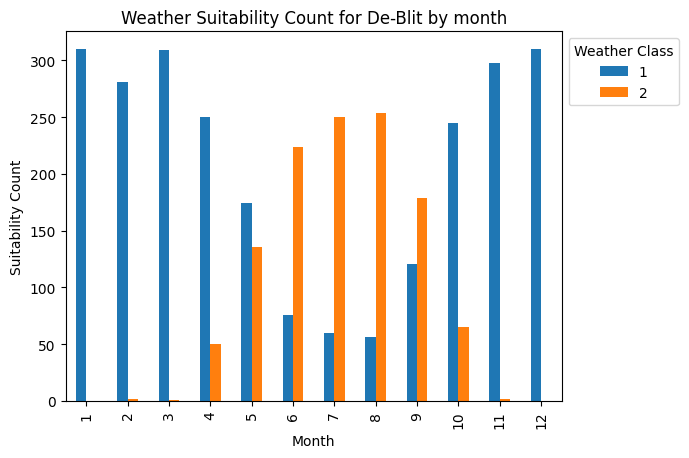

<Figure size 1000x600 with 0 Axes>

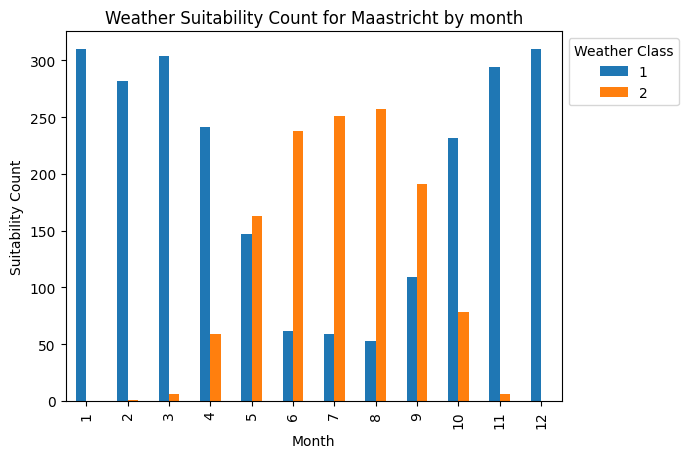

<Figure size 1000x600 with 0 Axes>

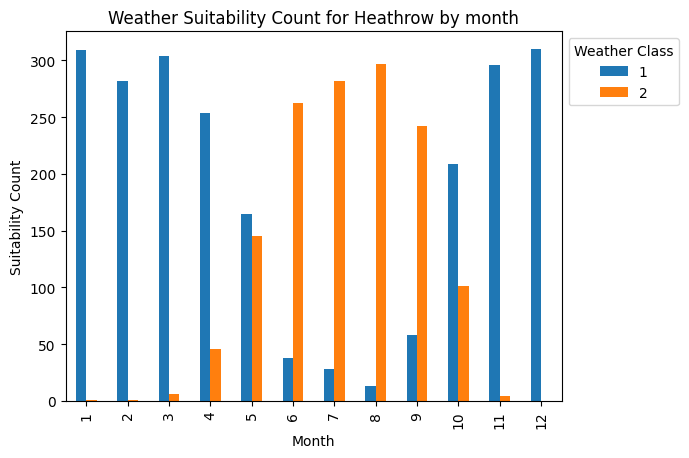

<Figure size 1000x600 with 0 Axes>

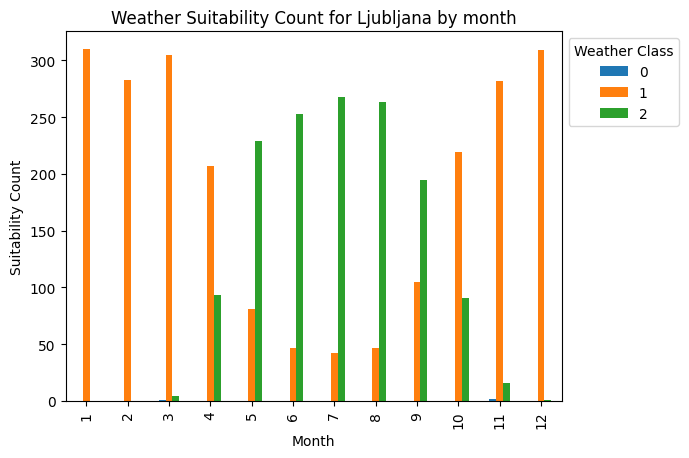

<Figure size 1000x600 with 0 Axes>

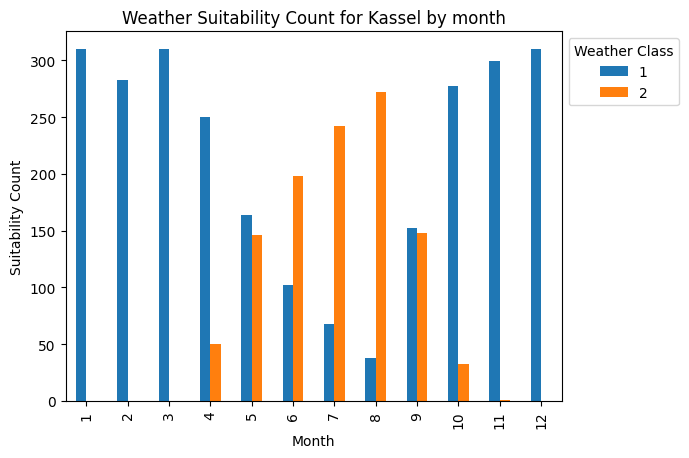

<Figure size 1000x600 with 0 Axes>

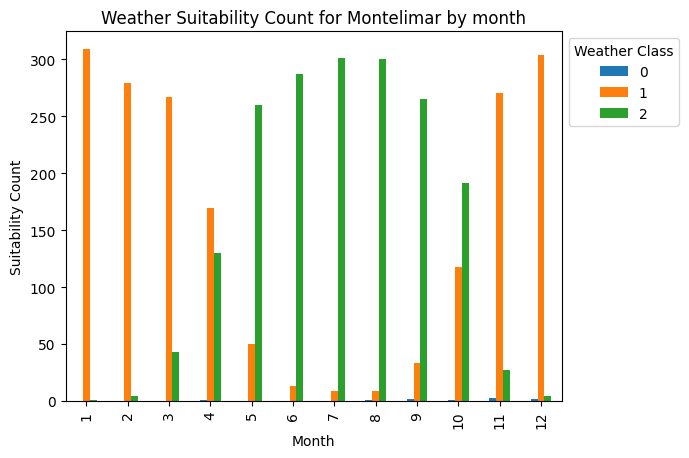

<Figure size 1000x600 with 0 Axes>

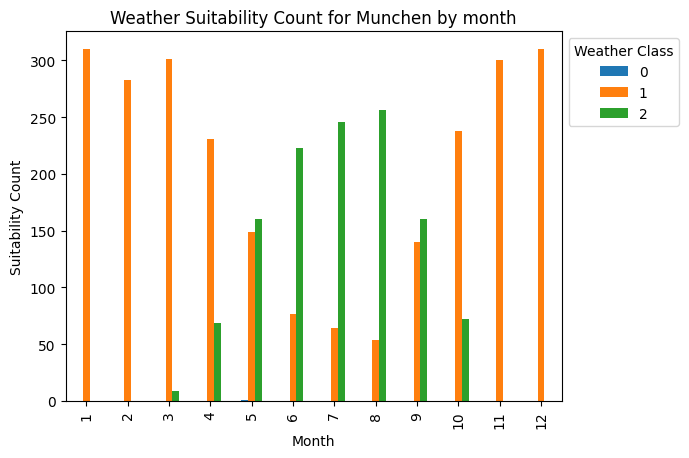

<Figure size 1000x600 with 0 Axes>

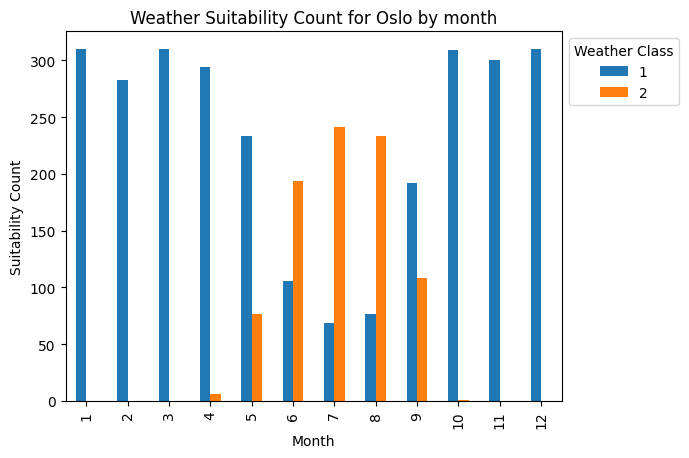

<Figure size 1000x600 with 0 Axes>

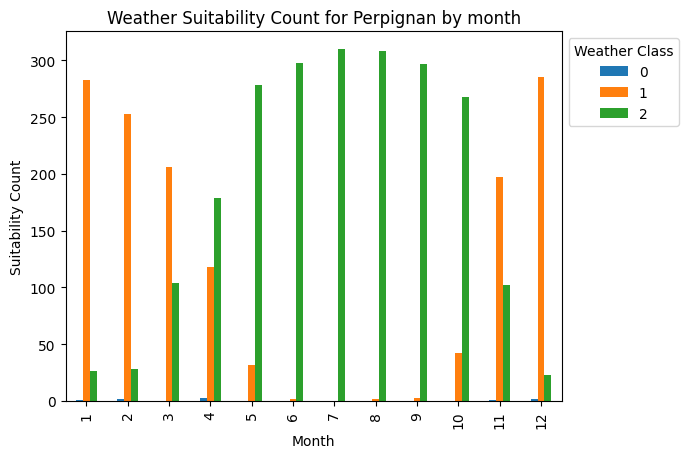

<Figure size 1000x600 with 0 Axes>

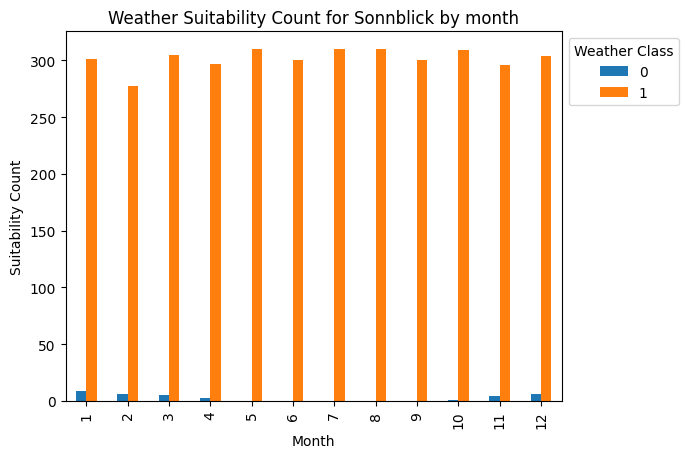

<Figure size 1000x600 with 0 Axes>

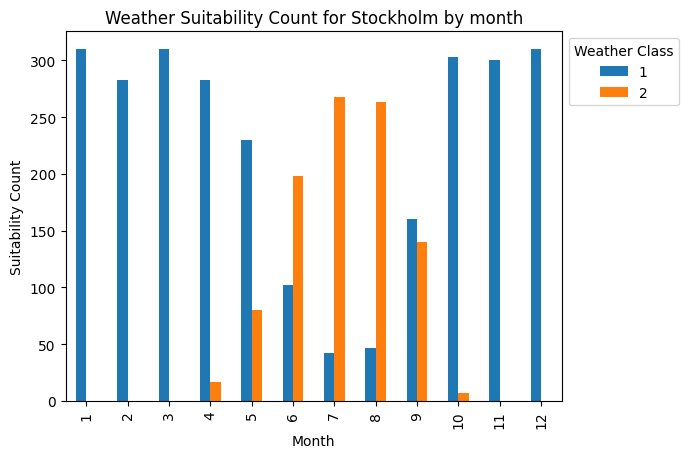

<Figure size 1000x600 with 0 Axes>

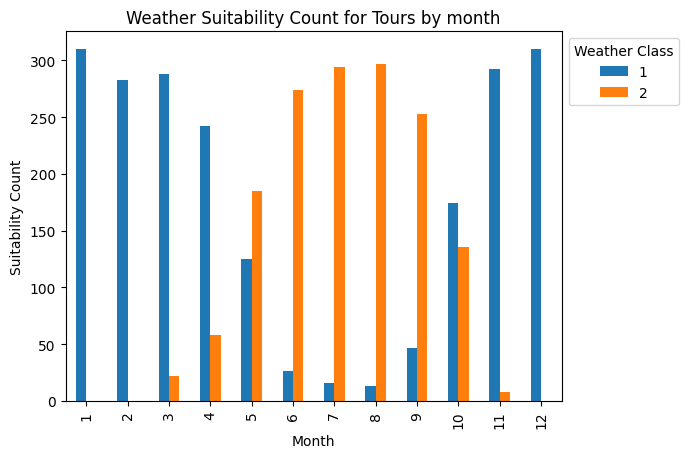

In [ ]:
# Iterate through each city and create a separate plot
for city in unique_cities:
    # Filter the DataFrame for the current city
    city_df = pandas_df[pandas_df['CITY'] == city]

    # Create a crosstab for the current city
    crosstab_df_month = pd.crosstab(city_df['MONTH'], city_df['Weather_Class'])

    # Create a clustered bar plot for the current city
    plt.figure(figsize=(10, 6))  # Set the figure size
    crosstab_df_month.plot(kind='bar', stacked=False)  # Create the clustered bar plot

    plt.xlabel('Month')  # Set the x-axis label
    plt.ylabel('Suitability Count')  # Set the y-axis label
    plt.title(f'Weather Suitability Count for {city} by month')  # Set the plot title

    plt.legend(title='Weather Class', bbox_to_anchor=(1, 1))  # Add a legend
    plt.show()  # Show the plot


#Train a model

Task: predict weather (Suitable/ Moderate/ Not suitable) for the next day based on single-day weather observations.

Tool: Python + Scikit-learn

In [ ]:
df.show()

+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|Weather_Class|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|    0.89|            1|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|    0.87|            1|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|    0.81|            1|
|2000|    1|   4|Switzerland|Basel|          7|  1.0262|            0.63|         0.35|     6.9|      3.9|    0.79|            1|
|2000|    1|   5|Switzerland|Basel|          5|  1.0246|            0.51|         0.07|   

In [ ]:
# Define the columns to encode
columns_to_encode = ['CITY', 'COUNTRY']

# Create StringIndexer objects for each column
indexers = [StringIndexer(inputCol=column, outputCol=column + '_encoded') for column in columns_to_encode]

# Fit and transform the data using the StringIndexers
indexers = [indexer.fit(df) for indexer in indexers]

for indexer in indexers:
    df = indexer.transform(df)

# Display the encoded DataFrame
df.show()

+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+------------+---------------+
|YEAR|MONTH|DATE|    COUNTRY| CITY|Cloud_cover|Pressure|Global_radiation|Precipitation|Sunshine|Temp_mean|Humidity|Weather_Class|CITY_encoded|COUNTRY_encoded|
+----+-----+----+-----------+-----+-----------+--------+----------------+-------------+--------+---------+--------+-------------+------------+---------------+
|2000|    1|   1|Switzerland|Basel|          8|  1.0286|             0.2|         0.03|     0.0|      2.9|    0.89|            1|         0.0|            8.0|
|2000|    1|   2|Switzerland|Basel|          8|  1.0318|            0.25|          0.0|     0.0|      3.6|    0.87|            1|         0.0|            8.0|
|2000|    1|   3|Switzerland|Basel|          5|  1.0314|             0.5|          0.0|     3.7|      2.2|    0.81|            1|         0.0|            8.0|
|2000|    1|   4|Switzerland|Basel|          7

In [ ]:
# Select the 'COUNTRY' and 'Country_encoded' columns
country_label_df = df.select('COUNTRY', 'Country_encoded')

# Collect the data into a list of rows
country_label_rows = country_label_df.collect()

# Create a dictionary from the collected data
country_label_dict = {row['COUNTRY']: row['Country_encoded'] for row in country_label_rows}

# Print the dictionary
print(country_label_dict)

{'Switzerland': 8.0, 'Hungary': 4.0, 'Germany': 0.0, 'Netherlands': 2.0, 'UK': 9.0, 'Slovenia': 6.0, 'France': 1.0, 'Norway': 5.0, 'Austria': 3.0, 'Sweden': 7.0}


In [ ]:
# Select the 'CITY' and 'City_encoded' columns
city_label_df = df.select('CITY', 'City_encoded')

# Collect the data into a list of rows
city_label_rows = city_label_df.collect()

# Create a dictionary from the collected data
city_label_dict = {row['CITY']: row['City_encoded'] for row in city_label_rows}

# Print the dictionary
print(city_label_dict)

{'Basel': 0.0, 'Budapest': 1.0, 'Dresden': 3.0, 'Dusseldorf': 4.0, 'De-Blit': 2.0, 'Maastricht': 8.0, 'Heathrow': 5.0, 'Ljubljana': 7.0, 'Kassel': 6.0, 'Montelimar': 9.0, 'Munchen': 10.0, 'Oslo': 11.0, 'Perpignan': 12.0, 'Sonnblick': 13.0, 'Stockholm': 14.0, 'Tours': 15.0}


In [ ]:
# Define the feature columns (excluding 'Weather_Class', 'CITY', and 'COUNTRY')
feature_cols = ['YEAR','MONTH','DATE','COUNTRY_encoded','CITY_encoded','Cloud_cover','Pressure','Global_radiation','Precipitation', 'Sunshine','Temp_mean','Humidity']

# Create a VectorAssembler to assemble the feature columns into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Use the VectorAssembler to transform the DataFrame
X = vector_assembler.transform(df)

In [ ]:
# Split the data into training and testing sets
train_ratio = 0.7
test_ratio = 1 - train_ratio
train_df, test_df = X.randomSplit([train_ratio, test_ratio], seed=42)

# Print the shape of the datasets
print("Training Set Rows:", train_df.count())
print("Testing Set Rows:", test_df.count())

Training Set Rows: 40890
Testing Set Rows: 17558


**Random Forest Classifier**

In [ ]:
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="Weather_Class")

# Fit the model on the training data
model = rf_classifier.fit(train_df)

In [ ]:
# Make predictions on the test data
predictions = model.transform(test_df)

In [ ]:
# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="Weather_Class", predictionCol="prediction", metricName="accuracy")
# Calculate accuracy, precision, recall, and F1-score
accuracy = evaluator.evaluate(predictions)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Accuracy: 0.9774
Precision: 0.9767
Recall: 0.9774
F1-Score: 0.9770


In [ ]:
# Calculate the confusion matrix manually
confusion_matrix = predictions.groupBy("Weather_Class", "prediction").count()

# Show the confusion matrix
confusion_matrix.show()

+-------------+----------+-----+
|Weather_Class|prediction|count|
+-------------+----------+-----+
|            2|       1.0|   97|
|            1|       2.0|  282|
|            2|       2.0| 6015|
|            1|       1.0|11146|
|            0|       1.0|   18|
+-------------+----------+-----+

